# Targeted Advertising in Snapchat Political Ads
### Cyril Gorlla
#### University of California, San Diego

## Summary of Findings

Snapchat is one of the most popular social media apps in the world. It is no surprise, then, that many political ads are run on the service each year. Snap Inc.'s [political ads library](https://www.snap.com/en-US/political-ads/) is part of an effort by the company to increase transparency in their advertising practices. The data analyzed in this project spans 2019-2020, and consists of information on every political ad that was run on the service in that timeframe, including who the ad buyer was, how much the ad cost, what areas it targeted, etc. 

The main dataset used in this project was created by combining two datasets for each year. The start and end dates were converted to standard Pandas datetime format, and any spend amounts not in USD were converted to USD with forex_python to allow for more meaningful statistical analyses. To narrow focus on those advertisements which were targeted, the dataset was filtered to consist of ads that 

- Were targeting the United States
- Specifically targeted a state or states.

The final dataset consisted of 1,175 rows, compared with the original 5,432. The rows with ads in the United States not targeted to a specific state are irrelevant to these analyses as they would simply have their spend amount distributed across all 50 states, making that data effectively worthless. To be able to work with data on a state-by-state level, the dataset had to be transformed as it had multiple states on one row if more than one state was targeted. To achieve this, rows for each state were created from the same ad if it targeted multiple states, and the spend amount was evenly distributed between the states. 

Looking at raw amounts of ad money spent on each state is moot as there would be an obvious bias to states with higher population. Thus, we use [a normalization equation](https://digital.gov/2016/03/11/seeing-states-the-right-way-how-to-weigh-data-by-population/) from the U.S. government and data from the [census bureau](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_500989927) to normalize money spent in each state with its respective population.

To ascertain the nature of missingness in the original dataset, the `Segments` column was chosen as there is no explanation from Snapchat about why this particular column would be missing. It would not seem plausible at first glance that the data is  This column is "advertiser-specific data used such as Snap Audience Match or Lookalike audiences." Permutation tests were run with the first 15 columns of the dataset to see if there was any relation between the missingness seen in Segments and the total variation distance of that particular column. It was determined with α = 0.05 that Segments is missing at random dependent on the `CandidateBallotInformation` column (p = 0.02). This makes sense as ads specifically supporting a candidate for political office would likely have data on individuals already, which would be in Segments. In contrast, the missingness of segments is likely not influenced by `Impressions` (p = 0.87) so the amount of impressions likely has no effect on if Segments is missing. Note: There is no missing data relevant to ad targeting, as if there is no data in a column related to targeting it simply means that the ad was not targeted at that level.

Finally, it was observed through geospatial plotting that Vermont seemed to have an abnormally high amount of ad dollars spent relative to its population. To further look into this, a question was posed of whether or not Vermont is disproportionately advertised to, relative to its population and other states. Specifically:

- H0: The null hypothesis is that Vermont does not have an unusually high amount of money spent in ads targeted to it; any percieved abnormality is due to random chance.

- Ha: The alternative hypothesis says that there is indeed a disproportionately high amount of money spent in advertising to Vermont.

The test statistic used was the normalized amount of money spent on Snapchat political ads in Vermont. For the hypothesis test, the column containing normalized amounts spent was repeatedly shuffled randomly, and the amount that was spent on Vermont in that particular random simulation was recorded. After all simulations were done, the likelihood of seeing the observed values in the set of simulated values was calculated. With α = 0.05 the null hypothesis was rejected (p = 0.02). While this does not mean the alternative hypothesis can be accepted, it does mean that the distribution of ad dollars to Vermont is not wholly random.

## Cleaning and EDA

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import folium
import plotly.graph_objects as go
from forex_python.converter import CurrencyRates
c = CurrencyRates()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [5]:
df19 = pd.read_csv('2019.csv')
df20 = pd.read_csv('2020.csv')
#concatenate both years together
sc = pd.concat([df19,df20],ignore_index=True)
#convert dates to datetime
sc['StartDate'] = pd.to_datetime(sc['StartDate'])
sc['EndDate'] = pd.to_datetime(sc['EndDate'])
converted = sc[sc['Currency Code'] != 'USD'].apply(lambda row: c.convert(row['Currency Code'], 'USD', int(row['Spend'])), axis=1)
#convert non-USD currencies into USD
sc.loc[(sc['Currency Code'] != 'USD'),'Spend'] = converted
sc = sc.drop('Currency Code', axis=1)

In [36]:
sc.head()

ADID  \
0  299815fc312c9ac3558d5d03b22909f02b3583727333fb...   
1  db157a823c6190b460ebdcda8c0346814592b7c107ba58...   
2  7033c3858de78f6e1f7dc5f47d1e5288df1a631e342200...   
3  b04be410e42e36b34db7f2bf6eb1447ba2a6757b4cc513...   
4  9e6e16e5a7bbebe495bd8725017725e1c6be52329a84a8...   

                                         CreativeUrl         Spend  \
0  https://www.snap.com/political-ads/asset/9e88f...   4187.000000   
1  https://www.snap.com/political-ads/asset/4a68a...   1576.000000   
2  https://www.snap.com/political-ads/asset/6d820...  99361.000000   
3  https://www.snap.com/political-ads/asset/212b0...  10360.000000   
4  https://www.snap.com/political-ads/asset/71e1a...    246.137571   

   Impressions                 StartDate                   EndDate  \
0      1183287 2019-09-27 12:29:18+00:00 2019-10-05 14:00:00+00:00   
1       190847 2019-03-20 13:00:00+00:00 2019-04-04 03:59:59+00:00   
2     84687140 2019-10-23 13:00:00+00:00 2019-11-16 07:59:59+00:00   
3      2555940 2019-09-30 14:00:00+00:00 2020-06-29 03:59:00+00:00   
4       323890 2019-06-03 07:00:00+00:00 2019-09-04 06:59:59+00:00   

     OrganizationName                                     BillingAddress  \
0    Around The Clock  Business Central Tower A, Office 2304A, Dubai ...   
1  Unilever US - 360i        32 Avenue of the Americas,New York,10013,US   
2     Mediavest Spark  375 Hudson Street     Attention: Mailroom,New ...   
3            Assembly   711 3rd Ave, New York, NY 10017,new york city...   
4      The Aber Group     202-120 Eglinton Avenue East,Toronto,M4P1E2,CA   

  CandidateBallotInformation          PayingAdvertiserName  ...  \
0                        NaN      Federal National Council  ...   
1                        NaN                 Ben & Jerry's  ...   
2                        NaN  Recreational Equipment, Inc.  ...   
3                        NaN                         truth  ...   
4                        NaN     Plan International Canada  ...   

  Location Categories (Included) Location Categories (Excluded)  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

                                           Interests OsType  \
0  Automotive Enthusiasts,Film & TV Fans,Movie Th...    NaN   
1            Political News Watchers,ZZ_Deprecated_1    NaN   
2  Adventure Seekers,Hipsters & Trendsetters,Conc...    NaN   
3                                                NaN    NaN   
4                                                NaN    NaN   

                 Segments Language  AdvancedDemographics  \
0  Provided by Advertiser       ar                   NaN   
1                     NaN       en                   NaN   
2                     NaN      NaN                   NaN   
3  Provided by Advertiser      NaN                   NaN   
4                     NaN       en                   NaN   

  Targeting Connection Type Targeting Carrier (ISP)  \
0                       NaN                     NaN   
1                       NaN                     NaN   
2                       NaN                     NaN   
3                       NaN                     NaN   
4                       NaN                     NaN   

                                  CreativeProperties  
0                web_view_url:https://www.uaenec.ae/  
1  web_view_url:https://www.benjerry.com/values/i...  
2                                                NaN  
3  web_view_url:https://www.thetruth.com/o/articl...  
4  web_view_url:https://plancanada.ca/ChangeTheBi...  

[5 rows x 33 columns]

What percentage of each column is missing? It turns out some fields appear to be mandatory with 0% missing, while others are missing quite frequently. This is inline with the readme file.

In [7]:
sc.isnull().mean() * 100

ADID                                0.000000
CreativeUrl                         0.000000
Spend                               0.000000
Impressions                         0.000000
StartDate                           0.000000
EndDate                            22.974963
OrganizationName                    0.000000
BillingAddress                      0.000000
CandidateBallotInformation         77.927099
PayingAdvertiserName                0.000000
Gender                             92.304860
AgeBracket                          7.768778
CountryCode                         0.000000
Regions (Included)                 70.931517
Regions (Excluded)                 97.091311
Electoral Districts (Included)     98.803387
Electoral Districts (Excluded)    100.000000
Radius Targeting (Included)        94.108984
Radius Targeting (Excluded)        99.815906
Metros (Included)                  96.078792
Metros (Excluded)                  99.668630
Postal Codes (Included)            84.388807
Postal Cod

There appears to be a wide range of amounts spent in general.

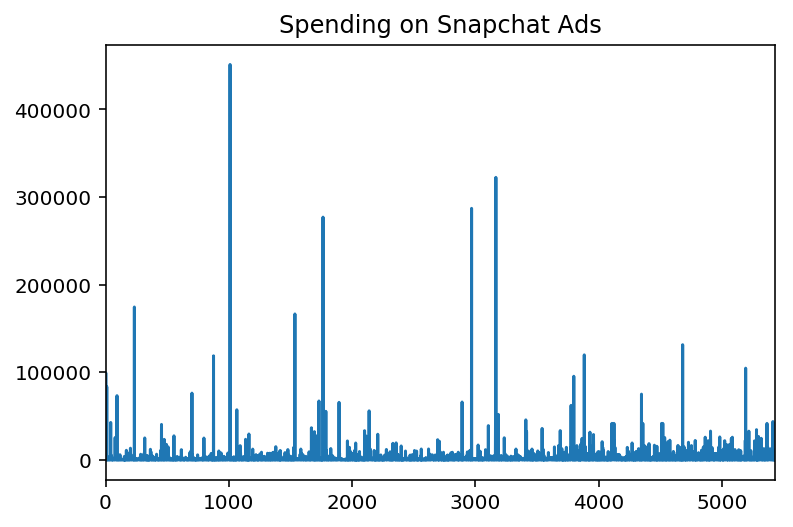

In [8]:
sc['Spend'].plot(title='Spending on Snapchat Ads')

In [9]:
us = sc[sc['CountryCode'] == 'united states']
region = us[us['Regions (Included)'].isna() == False]
#Filter the dataset to only include ads targeted to states in the US

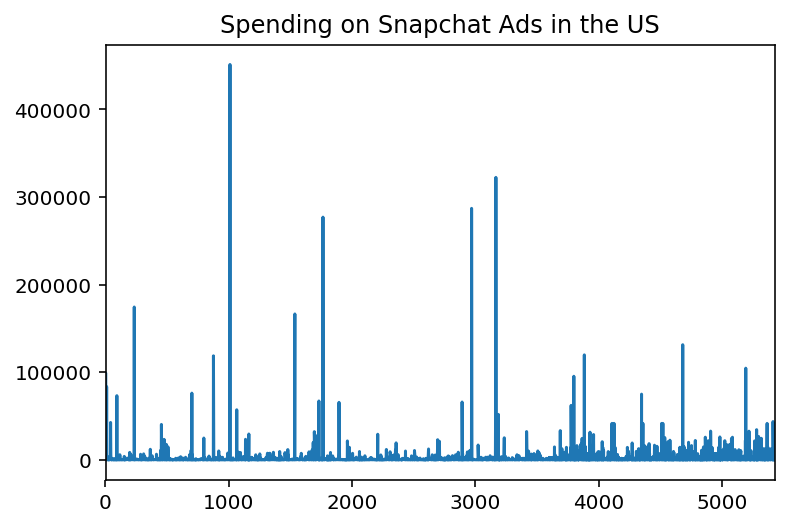

In [10]:
#This distribution appears identical to the global data
us['Spend'].plot(title='Spending on Snapchat Ads in the US')

State-targeted ads seem to have lower spending in general.

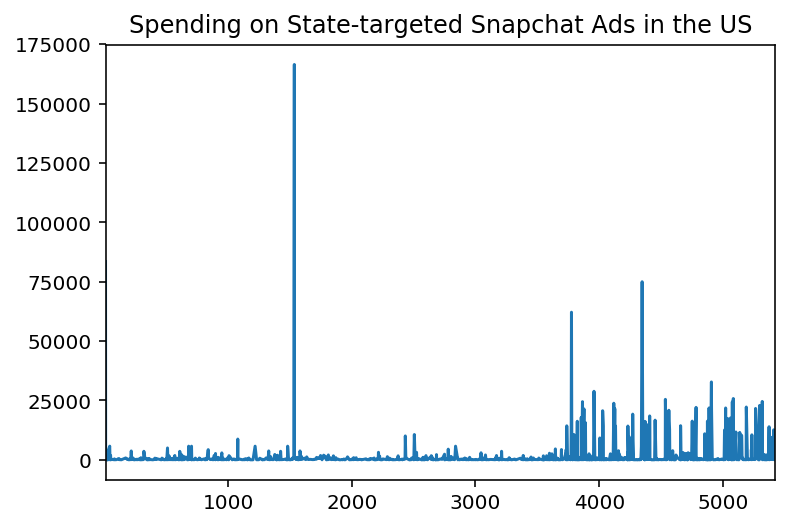

In [11]:
region['Spend'].plot(title='Spending on State-targeted Snapchat Ads in the US')

In [12]:
region['Spend'].describe()

count      1175.000000
mean       1593.186819
std        7170.062344
min           0.000000
25%          51.000000
50%         164.000000
75%         537.000000
max      166500.000000
Name: Spend, dtype: float64

We now look at ads with respect to the people posting them.

Text(0.5, 1.0, 'Number of Ads by Organization')

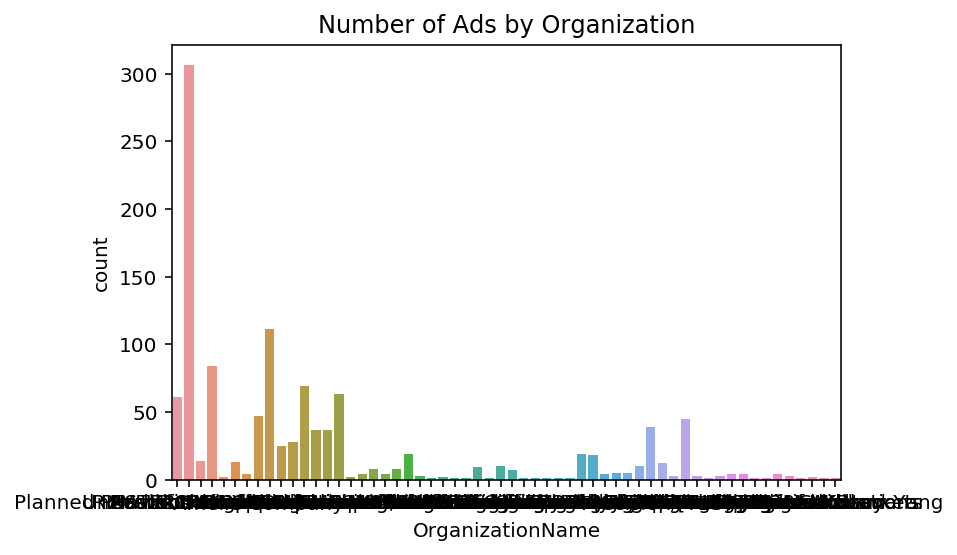

In [13]:
(sns.countplot(region['OrganizationName']).set_title('Number of Ads by Organization'))

In [14]:
region['OrganizationName'].describe()

count                     1175
unique                      58
top       UnRestrict Minnesota
freq                       306
Name: OrganizationName, dtype: object

In [37]:
region.groupby('OrganizationName')['Spend'].mean().sort_values(ascending=False).head()
#The highest average spenders

OrganizationName
Hawkfish LLC                         21100.803279
Omnicom Media Group Holdings Inc.     7486.000000
Red House Communications              7131.000000
Emmis Communcations                   5091.333333
RIESTER Sonoran LLC                   4395.000000
Name: Spend, dtype: float64

Text(0.5, 1.0, 'Spending by Organization')

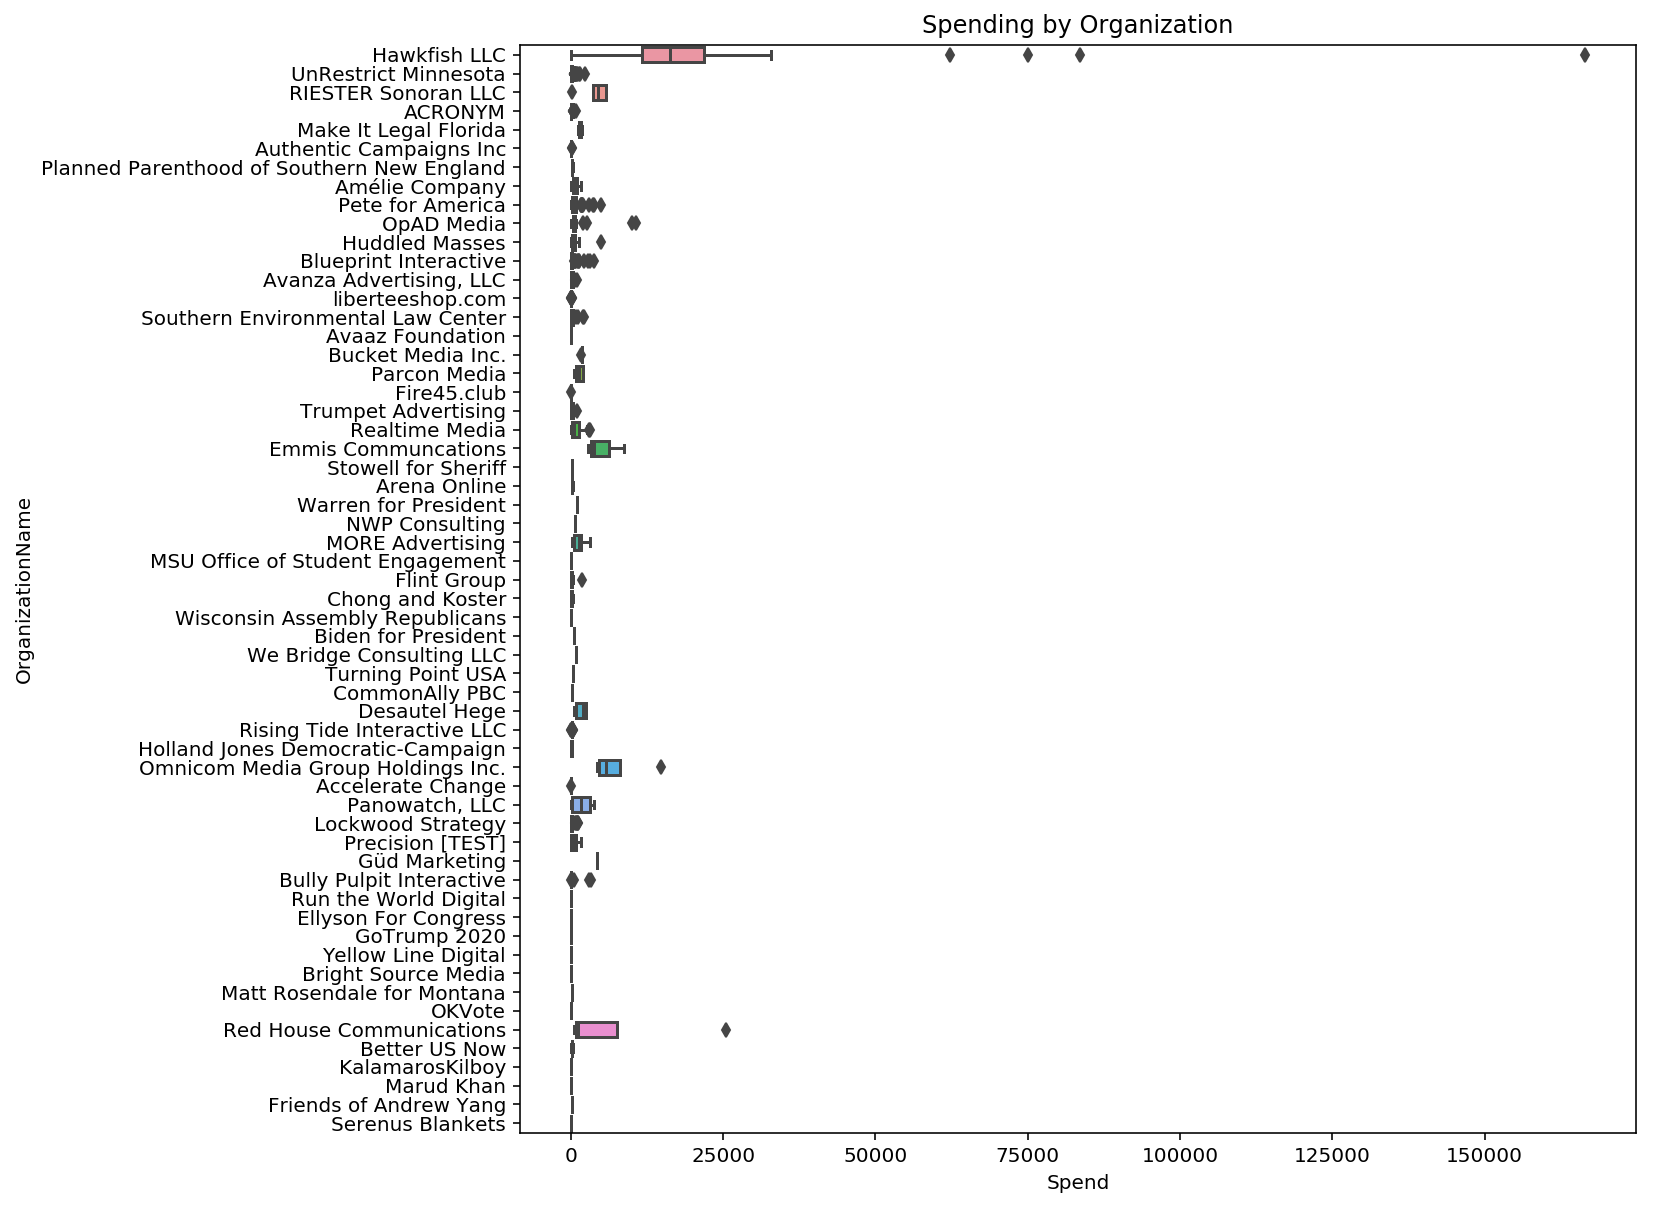

In [16]:
plt.figure(figsize=(10,10))
sns.boxplot(region['Spend'],region['OrganizationName']).set_title('Spending by Organization')

(0.0, 77.0, -17492.350000000002, 367339.35)

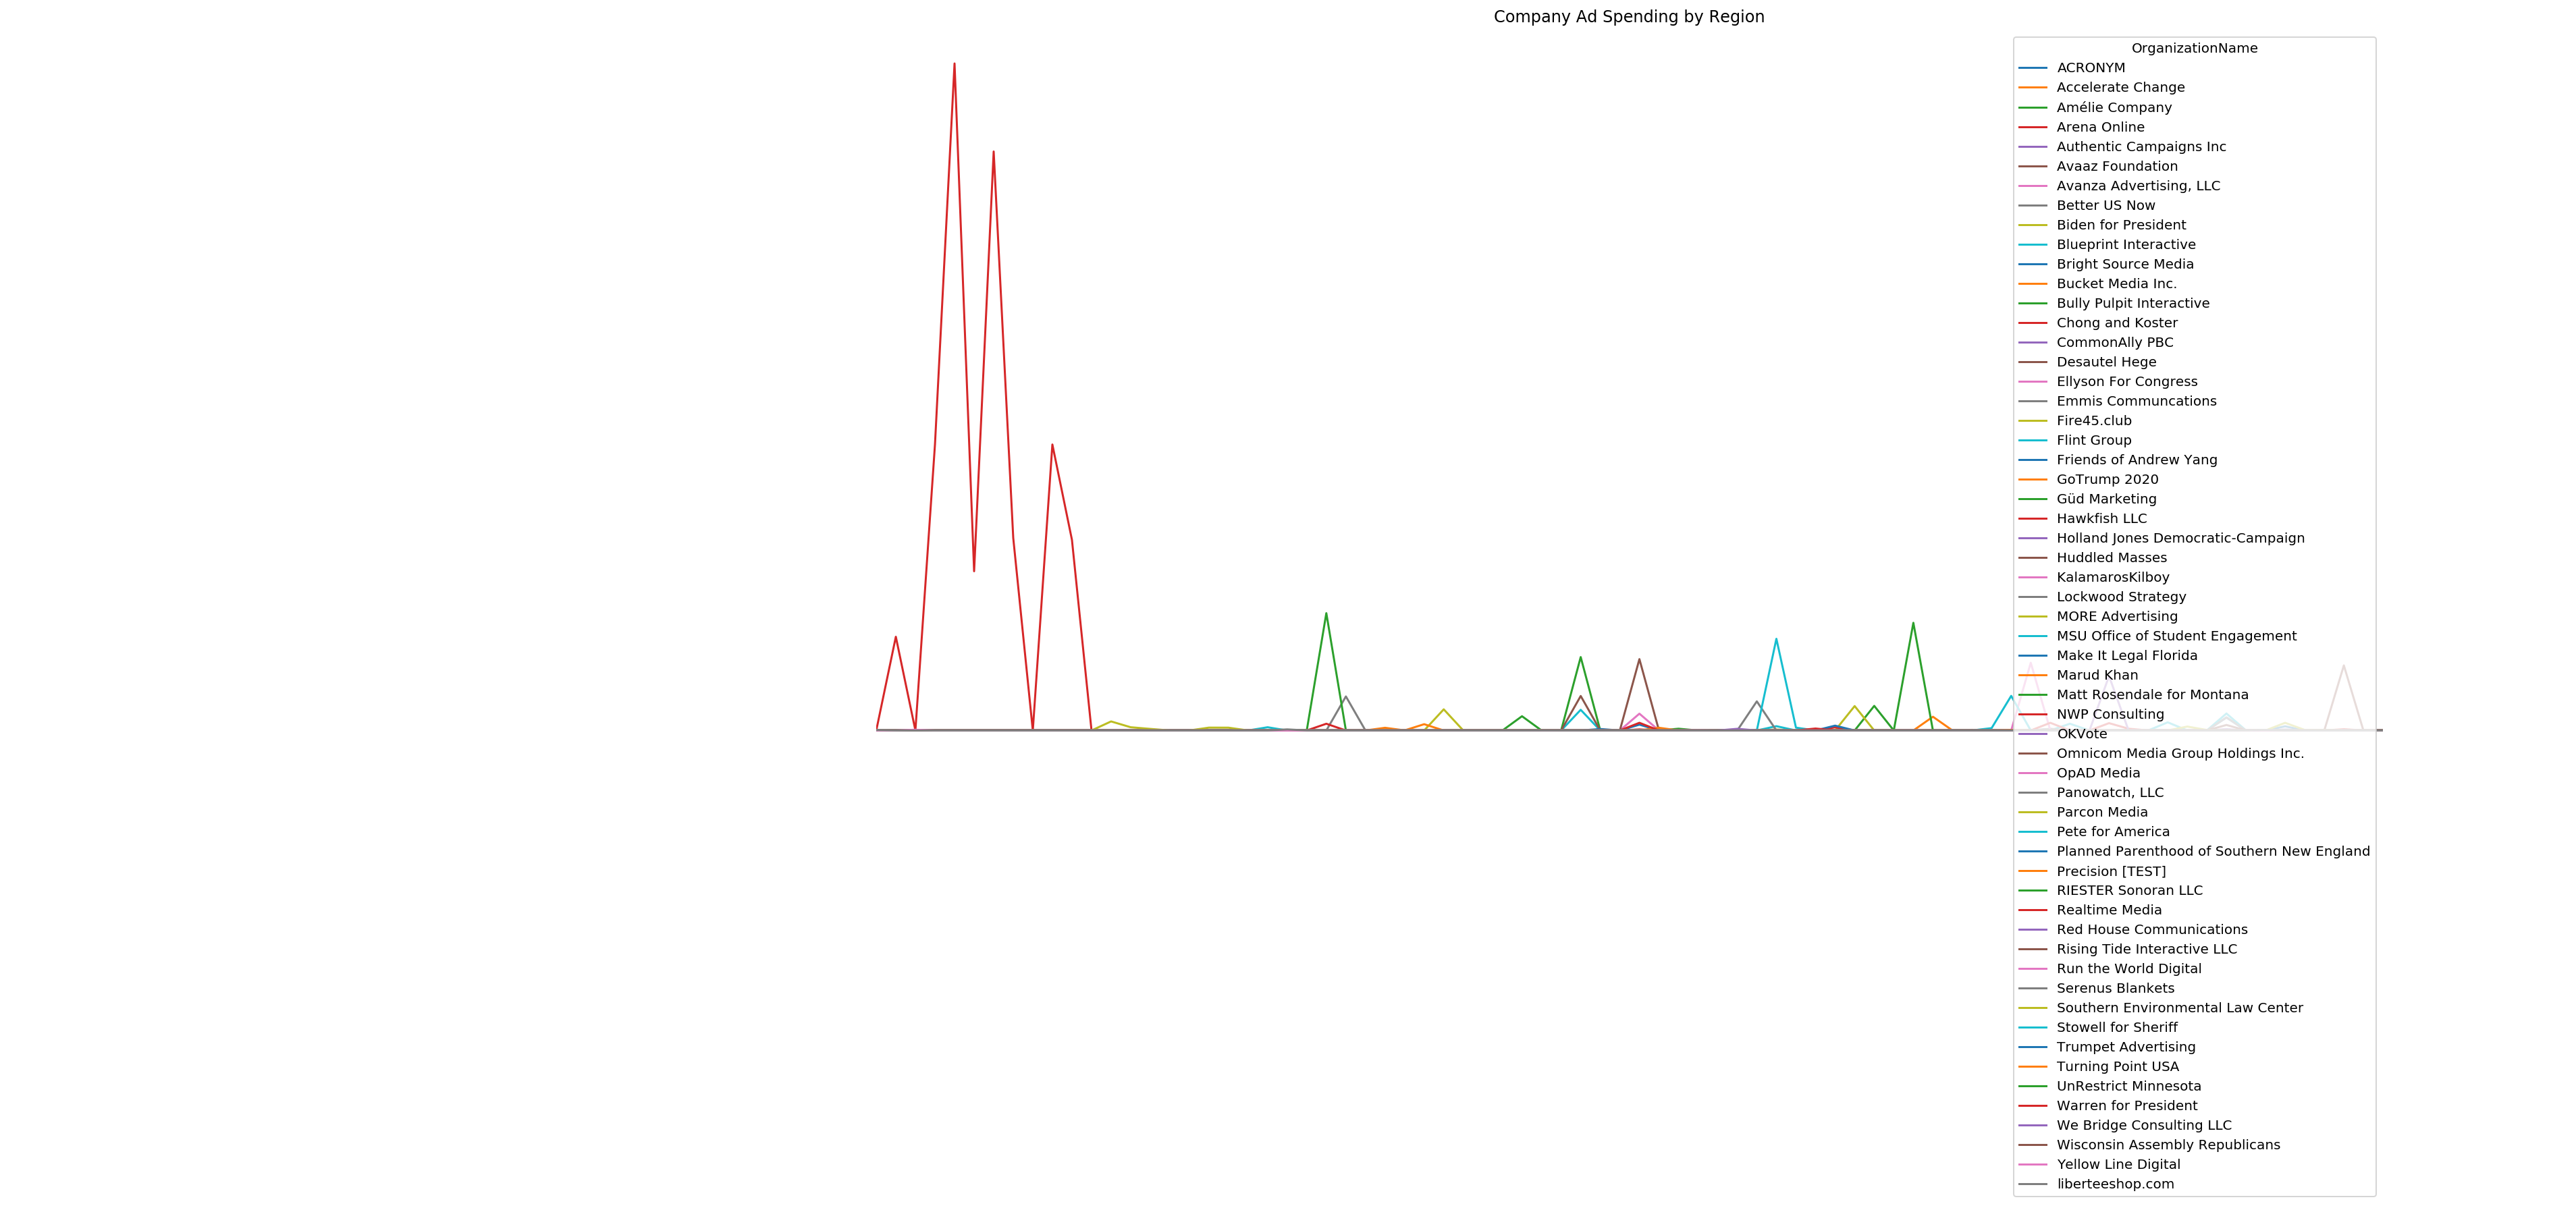

In [17]:
region.pivot_table(
    index='Regions (Included)', 
    columns='OrganizationName', 
    values='Spend', 
    aggfunc='sum',
    fill_value=0
).plot(figsize=(20,10),title='Company Ad Spending by Region')
plt.axis('off')

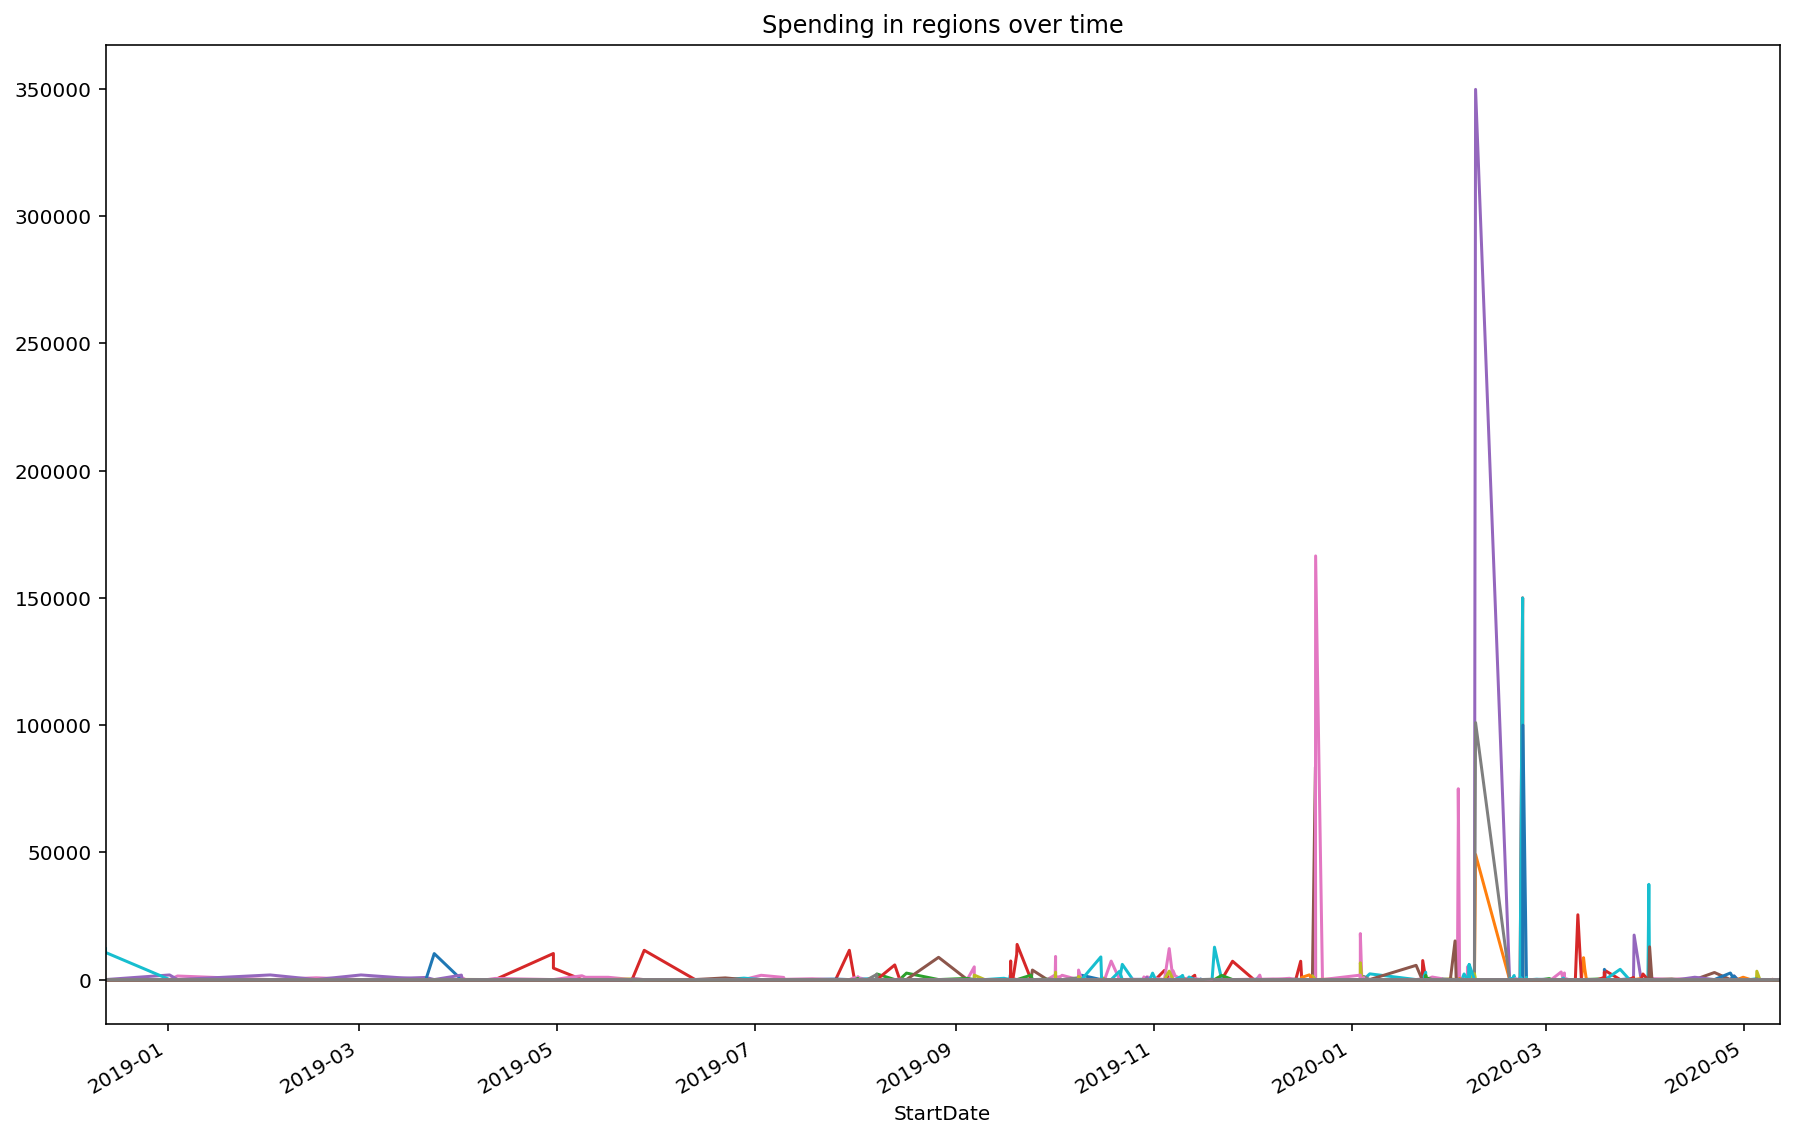

In [18]:
region.pivot_table(
    index='StartDate', 
    columns='Regions (Included)', 
    values='Spend', 
    aggfunc='sum',
    fill_value=0
).plot(title='Spending in regions over time',legend=False,figsize=(15,10))

In [31]:
#Get the spending by state by splitting each state into its own row
#Divide spend bt the number of states it's being spent on
region['SpendState'] = region['Spend'] /(region['Regions (Included)'].apply(lambda x: len(str(x).split(','))))
df2 = pd.DataFrame()
df2 = region['Regions (Included)'].str.split(',').apply(pd.Series)   
df2.index = region.SpendState
df2 = df2.stack().reset_index('SpendState')  

Text(0.5, 1.0, 'Number of Ads by State')

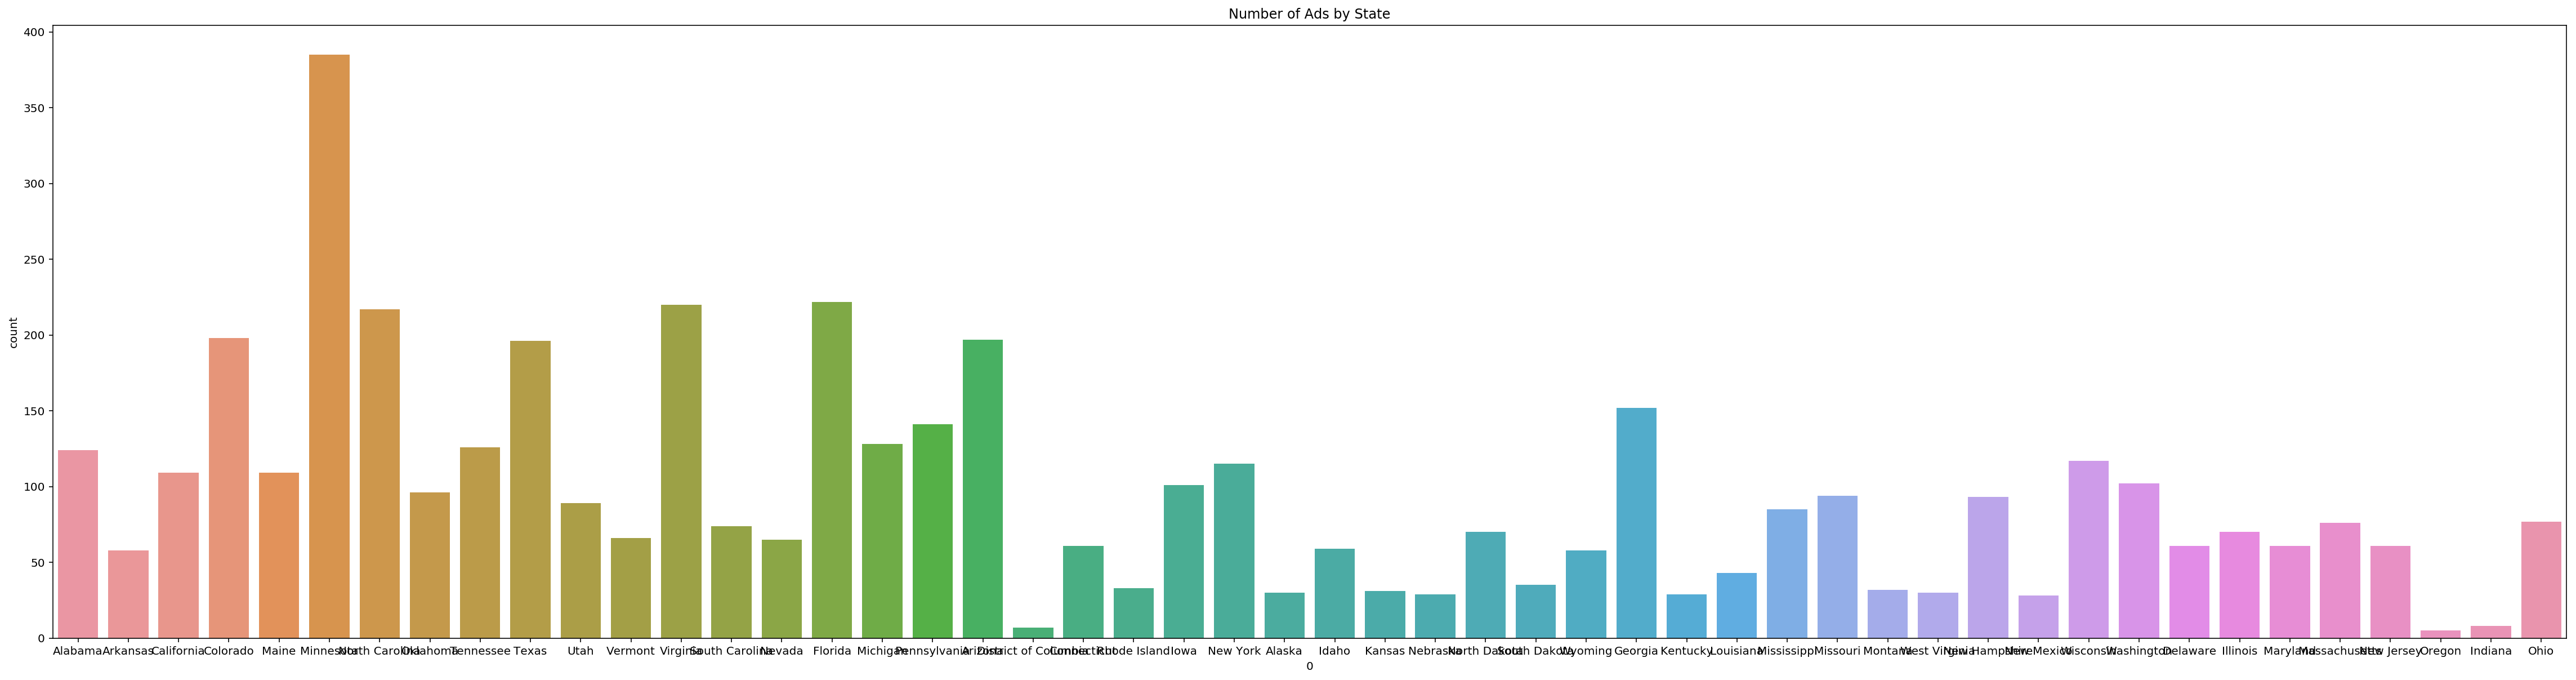

In [20]:
plt.figure(figsize=(40,10))
sns.countplot(df2[0]).set_title('Number of Ads by State')

In [21]:
df2[0].describe()

count          4673
unique           50
top       Minnesota
freq            385
Name: 0, dtype: object

In [38]:
state_spending = df2.groupby(0)['SpendState'].sum()
state_spending.head()
#spending by state

0
Alabama        51041.356787
Alaska           180.996241
Arizona       117559.364557
Arkansas       40836.880036
California     62477.076917
Name: SpendState, dtype: float64

In [23]:
pop = pd.read_csv('pop.csv') #census data from the Census Bureau
pop['State'] = pop['State'].str.strip('.')
pop['Population'] = pop['Population'].str.replace(',','').astype(float)
pop = pop.set_index('State')
df = pd.DataFrame(state_spending)
df = df.join(pop) #add population to the dataframe

In [24]:
df['SpendState_norm'] = (df['SpendState']/df['Population']) * 100000
#so we can normalize spending for each state

Text(0.5, 1.0, 'Spending relative to population')

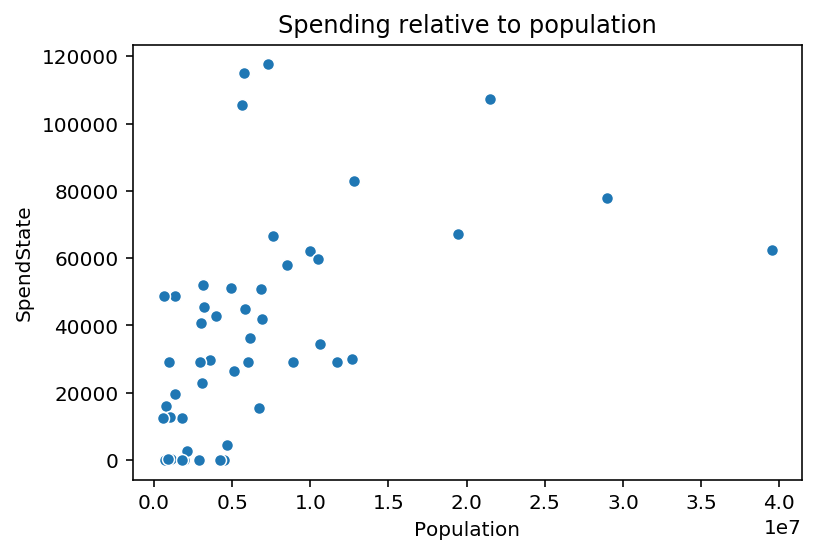

In [25]:
sns.scatterplot(df['Population'],df['SpendState']).set_title('Spending relative to population')

Text(0.5, 1.0, 'Normalized spending')

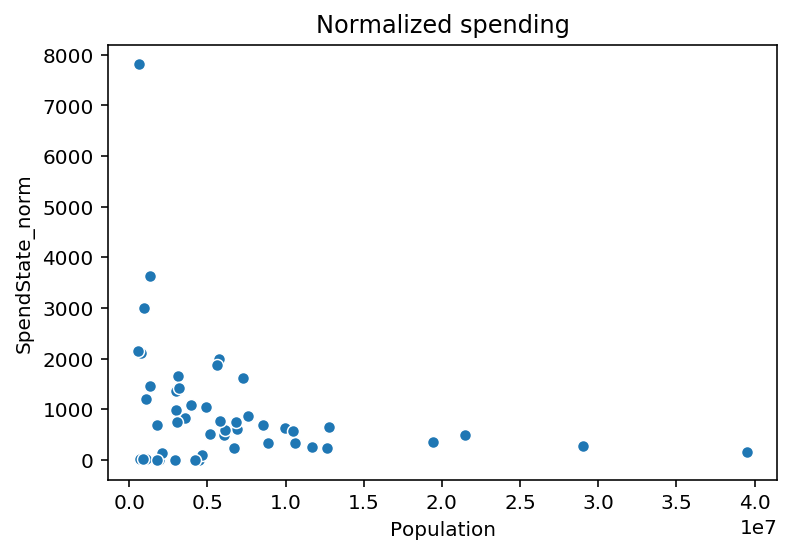

In [26]:
sns.scatterplot(df['Population'],df['SpendState_norm']).set_title('Normalized spending')

The raw spending has a predictable linear relationship while the normalized spending is relatively more constant.

In [39]:
df.sort_values(by='SpendState_norm',ascending=False).head()

SpendState  Population  SpendState_norm
0                                                      
Vermont       48720.944973    623989.0      7807.981386
Maine         48810.547246   1344212.0      3631.164373
Delaware      29112.833131    973764.0      2989.721650
Wyoming       12429.068796    578759.0      2147.537886
North Dakota  16078.902129    762062.0      2109.920470

It would appear Vermont is a hotspot.

In [35]:
fig = go.Figure(data=go.Choropleth(
    locations=np.array(pd.Series(df.index).map(us_state_abbrev)),
    z=df['SpendState_norm'],
    locationmode='USA-states',
    colorscale='mint',
    autocolorscale=False,
    marker_line_color='white',
    colorbar_title="USD"
))

fig.update_layout(
    title_text='Snapchat Political Ad Spending by State (Normalized)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

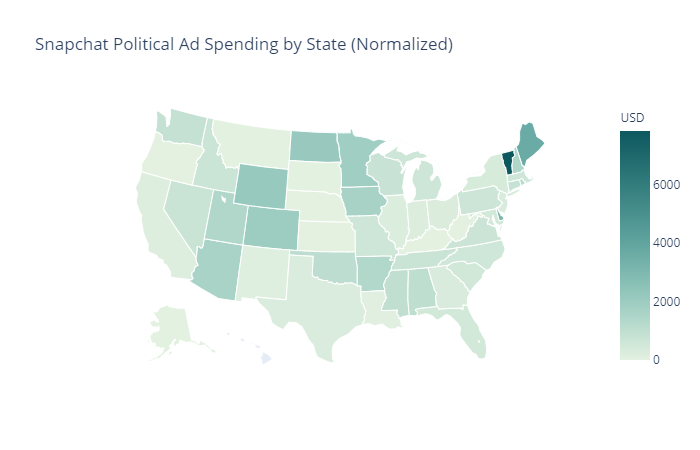

In [3]:
from IPython.display import Image
Image(filename='newplot.png') 

## Assessment of Missingness

Here we perform a permutation test to determine if the missingess of `Segments` is dependent on the first 15 columns of the data. α = 0.05

In [531]:
col = 'Segments'
for x in sc.columns[:15]:
    distr = (
        sc
        .assign(is_null=sc[col].isnull())
        .pivot_table(index='is_null', columns=x, aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )
    n_repetitions = 100

    tvds = []
    for _ in range(n_repetitions):

        # shuffle the current column
        shuffled_col = (
            sc[x]
            .sample(replace=False, frac=1)
            .reset_index(drop=True)
        )

        # put the shuffled column in a table
        shuffled = (
            sc
            .assign(**{
                x: shuffled_col,
                'is_null': sc[col].isnull()
            })
        )

        #total variation distance
        shuffled = (
            shuffled
            .pivot_table(index='is_null', columns=x, aggfunc='size')
            .apply(lambda x:x / x.sum(), axis=1)
        )

        tvd = shuffled.diff().iloc[-1].abs().sum() / 2
        # append

        tvds.append(tvd)
    obs = distr.diff().iloc[-1].abs().sum() / 2
    pval = np.mean(tvds > obs)
    print (x,pval)

ADID 0.0
CreativeUrl 1.0
Spend 0.0
Impressions 0.87
StartDate 1.0
EndDate 0.27
OrganizationName 0.0
BillingAddress 0.0
CandidateBallotInformation 0.02
PayingAdvertiserName 0.0
Gender 0.03
AgeBracket 0.0
CountryCode 0.0
Regions (Included) 0.0
Regions (Excluded) 0.99


With α = 0.05, we can say that Segments is missing dependent on the CandidateBallotInformation column (p = 0.02). This makes sense as ads specifically supporting a candidate for political office would likely have data on individuals already, which would be in Segments. In contrast, the missingness of segments is likely not influenced by Impressions (p = 0.87) so the amount of impressions likely has no effect on if Segments is missing.

## Hypothesis Test / Permutation Test

Is Vermont disproportionately targeted by Snapchat political ads, in terms of money spent advertising?

- H0: The null hypothesis is that Vermont does not have an unusually high amount of money spent in ads targeted to it; any percieved abnormality is due to random chance.

- Ha: The alternative hypothesis says that there is indeed a disproportionately high amount of money spent in advertising to Vermont.

Our test statistic will be the total amount of money (normalized) spent on Snapchat political ads targeted to Vermont from 2019-2020. α = 0.05

We will use the normalized data, because shuffling the raw amounts of money spent in each state is biased by the state's population. Using the normalized data eliminates this issue.

In [40]:
df.head()

SpendState  Population  SpendState_norm
0                                                     
Alabama      51041.356787   4903185.0      1040.983703
Alaska         180.996241    731545.0        24.741641
Arizona     117559.364557   7278717.0      1615.111077
Arkansas     40836.880036   3017804.0      1353.198552
California   62477.076917  39512223.0       158.120886

In [579]:
df.loc['Vermont']

SpendState          48720.944973
Population         623989.000000
SpendState_norm      7807.981386
Name: Vermont, dtype: float64

In [581]:
obs = df.loc['Vermont'][2]

In [582]:
stats = []
for x in range(5000):
    shuffled_col = ( #shuffle the amounts
        df['SpendState_norm']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    stats.append(shuffled_col[list(df.index).index('Vermont')])

In [583]:
np.count_nonzero(stats >= obs)/len(stats) #p-value is less than significance level

0.0204

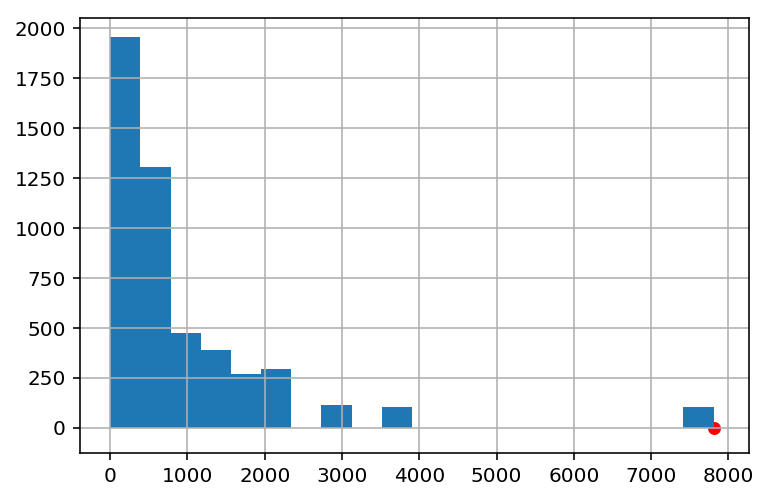

In [584]:
pd.Series(stats).hist(bins = 20)
plt.scatter(obs, 0, color='red', s=30);

We can see from the graph above that the observed result is seen very few times in the data we generated.

With α = 0.05 the null hypothesis is rejected (p = 0.02). While this does not mean the alternative hypothesis can be accepted, it does mean that the distribution of ad dollars to Vermont is not wholly random.